# osm_LoD1_3DCityModel Walkthrough

**The purpose of this notebook is to walk a user through [osm_LoD1_3DCityModel](https://github.com/AdrianKriger/osm_LoD1_3DCityModel/tree/main/village_campus).**


<div class="alert alert-block alert-warning"><b>This notebook will:</b>

> **1. allow the user to create a Level-of-Detail 1 (LoD1) [3D City Model](https://en.wikipedia.org/wiki/3D_city_model).**  *---It saves the `overpass`.geojson to prevent calling OSM after every failure. Peruse `matplotlib` figure at you leisure.* 
>
> **2. propose several [Geography and Sustainable Development Education *conversation starters*](#Section2) for Secondary and Tertiary level students**
</div>

<div class="alert alert-block alert-danger"><b>Please Note:</b>

***The [village](https://github.com/AdrianKriger/geo3D/tree/main/village)*** processing option is meant for areas with no more than for **2 500 buildings**.</div>

In [1]:
import time
from datetime import timedelta
import math

import os
from itertools import chain#, izip

import requests
import overpass
#import osm2geojson

import numpy as np
import pandas as pd
import geopandas as gpd
import topojson as tp

import shapely
import shapely.geometry as sg
from shapely.geometry import Point, LineString, Polygon, MultiPolygon, LinearRing, polygon, shape, mapping
from shapely.ops import snap
from shapely.ops import transform
from shapely.strtree import STRtree

import fiona
import copy
import json
import geojson

import pyproj

import city3D

from osgeo import gdal, ogr, osr

import triangle as tr

import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as MplPolygon
from matplotlib.collections import PatchCollection

In [2]:
import warnings
Tstart = time.time()
warnings.filterwarnings('ignore')

**A `parameter.json` defines the path and files**.

In [3]:
#- _param.json

#jparams = json.load(open('uEstate_param.json'))
#jparams = json.load(open('cput_param.json'))
#jparams = json.load(open('saao_param.json'))
jparams = json.load(open('mamre_param.json'))
#jparams = json.load(open('sRiver_param.json'))

**First get everything via `overpass`**

In [4]:
#buildings
query = """
    [out:json][timeout:25];
    area[name='{0}'] ->.b;
    // -- target area ~ can be way or relation
    {1}(area.b)[name='{2}'];
    map_to_area -> .a;
        // I want all buildings ~ with levels tagged
        (way['building'](area.a);
        // and relation type=multipolygon ~ to removed courtyards from buildings
        relation['building']["type"="multipolygon"](area.a);
    );
    out count;
    out geom;
    """.format(jparams['LargeArea'], jparams['osm_type'], jparams['FocusArea'])
    
#url = "http://overpass-api.de/api/interpreter"
#r = requests.get(url, params={'data': query})
#gj = osm2geojson.json2geojson(r.json())
#gj = osm2geojson.json2shapes(r.json())

#-- store the data as GeoJSON
#with open(jparams['ori-gjson_out'], 'w') as outfile:                   
#    json.dump(gj, outfile)

In [5]:
#- execute function and harvest blds. 
gdf = city3D.overpass_to_gdf(query)
gdf.head(2)

,building,building:levels,addr:city,addr:postcode,addr:street,addr:suburb,amenity,denomination,heritage,name,...,building:use,street_vendor,brand,opening_date,self_service,capacity,type,geometry,osm_id,osm_type
0,yes,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((18.4706033 -33.5057876, 18.4706995 -...",328118446,way
1,church,2,Cape Town,7347,Kerk Street,Mamre,place_of_worship,moravian,building,Mamre Moravian Church,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((18.4709153 -33.5059178, 18.4709287 -...",328118447,way


<div class="alert alert-block alert-danger"><b>NOTICE:</b>

***[village](https://github.com/AdrianKriger/geo3D/tree/main/village)*** will return a maximum of 2 500 buildings.</div>

In [6]:
#- some print statements
print('')
print(jparams['FocusArea'], 'has', len(gdf), 'buildings')
if int(len(gdf)) < 2500:
    print('\n\033[1mAll the buildings\033[0m  in', jparams['FocusArea'], 'have been harvested')
else:
    print('\n', int(len(gdf))-2500, "buildings have not been harvested.")


Mamre has 2300 buildings

All the buildings  in Mamre have been harvested


<div class="alert alert-block alert-info"><b></b>
    
Please do not burden the [OpenStreetMap](https://www.openstreetmap.org/about) server with excessive calls for data.

**If you need to investigate a larger area (> 2 500 buildings); choose *[suburb](https://github.com/AdrianKriger/geo3D/tree/main/suburb)* please.**</div>

In [7]:
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<img src="data/proj.png" alt="proj" width="550" align="right"/>
<br>
<br>

We need the ***Projected*** Coordinate Reference System.  

In [8]:
#- estimate utm: internal geopandas function
gdf.estimate_utm_crs()

<Projected CRS: EPSG:32734>
Name: WGS 84 / UTM zone 34S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 18°E and 24°E, southern hemisphere between 80°S and equator, onshore and offshore. Angola. Botswana. Democratic Republic of the Congo (Zaire). Namibia. South Africa. Zambia.
- bounds: (18.0, -80.0, 24.0, 0.0)
Coordinate Operation:
- name: UTM zone 34S
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<div class="alert alert-block alert-danger"><b>Your Participation! </b>
    
**Fill in the proper `espg` in the _`cell`_ below** </div>

In [9]:
#- fill <Projected CRS: EPSG:32734> from above here epsg = EPSG:32734
epsg = 32734

In [10]:
#project blds
gdf = gdf.to_crs(epsg)

In [11]:
query = """[out:json][timeout:30];
        area[boundary=administrative][name='{0}'] -> .a;
        (
        way[amenity~'university|research_institute'][name='{2}'](area.a);
        {1}[place][place~"sub|town|city|count|state|village|borough|quarter|neighbourhood"][name='{2}'](area.a);
        );
        out geom;
        """.format(jparams['LargeArea'], jparams['osm_type'], jparams['FocusArea'])

#url = "http://overpass-api.de/api/interpreter"
#r = requests.get(url, params={'data': query})
#rr = r.read()
#area = osm2geojson.json2geojson(r.json())

#-- store the data as GeoJSON
#with open(jparams['aoi'], 'w') as outfile:                  # set the path
#    json.dump(area, outfile)

#aoi = gpd.GeoDataFrame.from_features(area['features'])

#if jparams['osm_type'] == 'relation' and len(aoi) > 1:
#    for i, row in aoi.iterrows():
#        if row.tags != None and 'place' in row.tags:
#            focus = row
            
#    trim = pd.DataFrame(focus)
#    trim = trim.T
#    aoi = gpd.GeoDataFrame(trim, geometry = trim['geometry'])

# drop rows where geometry is None or NaN
#aoi = aoi.dropna(subset=['geometry'])
#aoi = aoi.set_crs(4326, allow_override=True)

aoi = city3D.overpass_to_gdf(query)
aoi.head(2)

,boundary,name,place,type,geometry,osm_id,osm_type
0,place,Mamre,village,boundary,"POLYGON ((18.4837963 -33.5141526, 18.4838104 -...",2198487,relation


**Now we process.**  

**If you change the *geometry, shape or alignment* of a building in an [OSM editor](https://wiki.openstreetmap.org/wiki/Editors); call / retrieve only what you need; and continue.**

In [12]:
#process aoi 

#aoi = gpd.read_file(jparams['aoi_prj'])  
aoi = aoi.to_crs(epsg)#=crs, inplace=True)#, allow_override=True)                      # set the crs
aoi.head(2)

,boundary,name,place,type,geometry,osm_id,osm_type
0,place,Mamre,village,boundary,POLYGON ((266289.9665682382 6288877.1009414345...,2198487,relation


In [13]:
aoibuffer = aoi.copy()

def buffer01(row):
    with np.errstate(invalid='ignore'):
        return row.geometry.buffer(150, cap_style=3, join_style=2)

aoibuffer['geometry'] = aoibuffer.apply(buffer01, axis=1)

# Suppose 'aoi' is your GeoDataFrameLite or list of geometries
geoms = aoi['geometry'].tolist()

#- combine all geometries into a single union
combined_geom = shapely.unary_union(geoms)  # returns Polygon or MultiPolygon
#- compute centroid
xy = (combined_geom.centroid.x, combined_geom.centroid.y)
#- compute bounding box
minx, miny, maxx, maxy = combined_geom.bounds
#bbox = [minx, miny, maxx, maxy]

#extent = [aoibuffer.total_bounds[0] - 250, aoibuffer.total_bounds[1] - 250, 
#          aoibuffer.total_bounds[2] + 250, aoibuffer.total_bounds[3] + 250]
extent = [minx - 250, miny - 250,
          maxx + 250, maxy + 250]

In [14]:
#extent

**Now the DEM**  
*three are available at [raster](https://github.com/AdrianKriger/geo3D/tree/main/raster)*

In [15]:
gdal.SetConfigOption("GTIFF_SRS_SOURCE", "GEOKEYS")

# set the path and nodata
OutTile = gdal.Warp(jparams['projClip_raster'], 
                    jparams['in_raster'],
                    dstSRS=f"EPSG:{epsg}",
                    srcNodata = jparams['nodata'],
                    #-  dstNodata = 0,
                    #-- outputBounds=[minX, minY, maxX, maxY]
                    outputBounds = [extent[0], extent[1], extent[2], extent[3]])
OutTile = None 

In [16]:
#- convert raster to XYZ in-memory

#- virtual in-memory path
xyz_mem_path = "/vsimem/temp_xyz.xyz"  
gdal.Translate(xyz_mem_path, jparams['projClip_raster'], format="XYZ")  

#- read XYZ from GDAL's in-memory file
xyz_vsimem = gdal.VSIFOpenL(xyz_mem_path, "rb")
xyz_bytes = gdal.VSIFReadL(1, gdal.VSIStatL(xyz_mem_path).size, xyz_vsimem)
gdal.VSIFCloseL(xyz_vsimem)
#- cleanup in-memory file
gdal.Unlink(xyz_mem_path) 

0

**prepare to harvest elevation**

In [17]:
# set the path to the projected, cliped elevation
src_filename = jparams['projClip_raster']

src_ds = gdal.Open(src_filename) 
gt_forward = src_ds.GetGeoTransform()
rb = src_ds.GetRasterBand(1)

def rasterQuery(geom, gt_forward, rb):

    mx = geom.representative_point().x
    my = geom.representative_point().y
    
    px = int((mx - gt_forward[0]) / gt_forward[1])
    py = int((my - gt_forward[3]) / gt_forward[5])

    intval = rb.ReadAsArray(px, py, 1, 1)
 
    return intval[0][0]

**Buildings**

In [18]:
gdf.head(2)

,building,building:levels,addr:city,addr:postcode,addr:street,addr:suburb,amenity,denomination,heritage,name,...,building:use,street_vendor,brand,opening_date,self_service,capacity,type,geometry,osm_id,osm_type
0,yes,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POLYGON ((265041.6351569728 6289775.0592048075...,328118446,way
1,church,2,Cape Town,7347,Kerk Street,Mamre,place_of_worship,moravian,building,Mamre Moravian Church,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((265070.9766813367 6289761.325392997,...",328118447,way


In [19]:
#- harvest buildings

ts = gdf.copy()
ts = ts.loc[:,~ts.columns.duplicated()]
#print(len(ts))

#- orient segments and simplify topology
#topo = tp.Topology(ts, prequantize=False, winding_order='CCW_CW')
#ts = topo.toposimplify(0.2).to_gdf()
#with np.errstate(invalid='ignore'):
#    ts = topo.toposimplify(0.25).to_gdf()

#- home-baked gdf
ts = city3D.GeoDataFrameLite(ts)
geojson_str = ts.to_json()
geojson_dict = json.loads(geojson_str)

#- orient segments and simplify topology
topo = tp.Topology(geojson_dict, prequantize=False, winding_order='CCW_CW')
with np.errstate(invalid='ignore'):
    #simplified = topo.toposimplify(0.25).to_gdf()
    simplified_geojson = topo.toposimplify(0.25).to_geojson()

#- convert back to home-baked gdf
ts = city3D.GeoDataFrameLite.from_json(simplified_geojson)
ts.crs = epsg

In [20]:
#ts.head(3)
#len(ts)

In [21]:
# prepare to plot (more buildings = more time) 
start = time.time()

ts_copy = ts.copy()
#new_df1 = ts_copy.loc[ts_copy.overlaps(ts_copy.unary_union)].reset_index(drop=True)  #-- perhaps no union?

geoms = ts_copy["geometry"].tolist()
tree = STRtree(geoms)
# Find overlapping pairs
pairs = []
for i, geom in enumerate(geoms):
    # query returns candidates that intersect envelope
    candidates = tree.query(geom)
    for c in candidates:
        # find index by identity in the original geoms list
        try:
            j = next(idx for idx, g in enumerate(geoms) if g is c)
        except StopIteration:
            continue  # skip if candidate is not found
        if i != j and geom.overlaps(c):
            pairs.append((i, j))

joined = pd.DataFrame(pairs, columns=["index_left", "index_right"])

#joined = gpd.sjoin(gdf_copy, gdf_copy, how="inner", predicate="overlaps")

#- joined index is changing. silence warning. future ready.
# GeoPandas <0.12 uses index_left/index_right
#if "index_left" in joined.columns:
#    left_idx = joined["index_left"]
#    right_idx = joined["index_right"]
#else:  # GeoPandas ≥0.12 uses _left/_right suffixes
#    left_idx = joined.index
#    right_idx = joined["index_right"]

# remove self matches
#mask = left_idx != right_idx
#overlap_idx = left_idx[mask].unique()

#- remove self matches and select overlapping geometries
left_idx = joined["index_left"]
right_idx = joined["index_right"]
mask = left_idx != right_idx
overlap_idx = left_idx[mask].unique()

new_df1 = ts_copy.loc[overlap_idx].reset_index(drop=True)
end = time.time()
print('runtime:', str(timedelta(seconds=(end - start))))

runtime: 0:00:00.187280


**Plot**

*Browse the saved `'./data/topologyFig'` at your leisure*

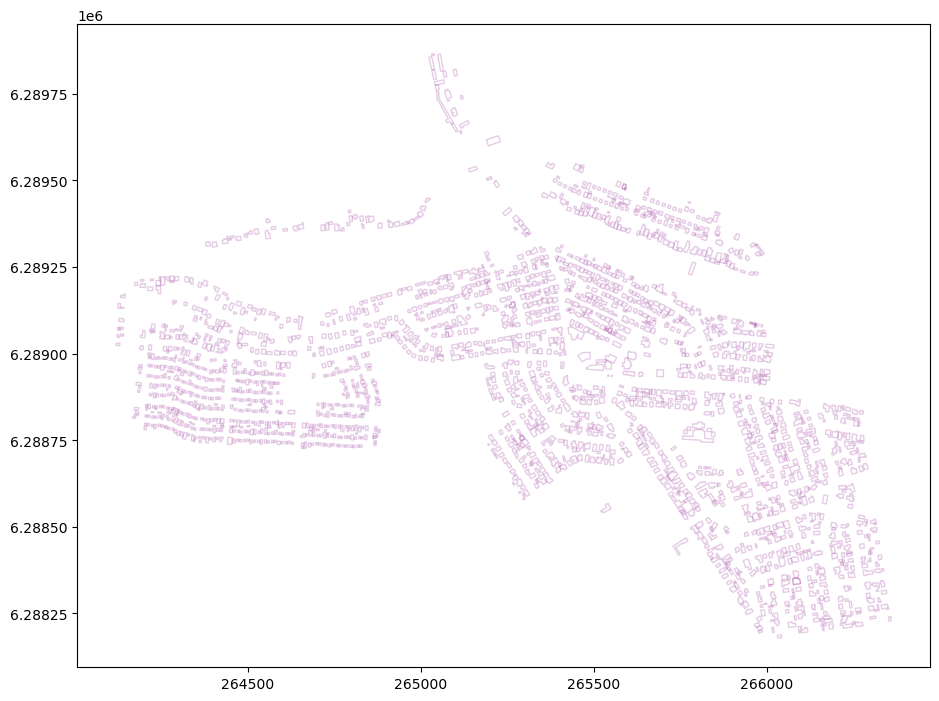

In [22]:
#%matplotlib

#fig, ax = plt.subplots(figsize=(11, 11))
#ts.plot(ax=ax, facecolor='none', edgecolor='purple', alpha=0.2)
#if len(new_df1) > 0:
#    new_df1.plot(ax=ax, edgecolor='red', facecolor='none')#, alpha=0.3)#, column='osm_building', legend=True)

def plot_geometries(df, ax=None, facecolor='none', edgecolor='purple', alpha=0.5):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,10))

    patches = []

    for geom in df['geometry']:
        if geom is None:
            continue

        if isinstance(geom, Polygon):
            # Exterior ring
            patches.append(MplPolygon(list(geom.exterior.coords), closed=True))
            # Interiors (holes)
            for interior in geom.interiors:
                patches.append(MplPolygon(list(interior.coords), closed=True))
        elif isinstance(geom, MultiPolygon):
            for poly in geom.geoms:
                patches.append(MplPolygon(list(poly.exterior.coords), closed=True))
                for interior in poly.interiors:
                    patches.append(MplPolygon(list(interior.coords), closed=True))

    pc = PatchCollection(patches, facecolor=facecolor, edgecolor=edgecolor, alpha=alpha)
    ax.add_collection(pc)
    ax.autoscale()
    ax.set_aspect('equal')
    return ax

#- usage:
fig, ax = plt.subplots(figsize=(11, 11))
plot_geometries(ts_copy, ax=ax, facecolor='none', edgecolor='purple', alpha=0.2)
if len(new_df1) > 0:
    plot_geometries(new_df1, ax=ax, facecolor='none', edgecolor='red', alpha=0.5)
#-- save
plt.savefig('./data/topologyFig.png', dpi=300)
#plt.show()

|  |  |
|:--------:|:--------:|
|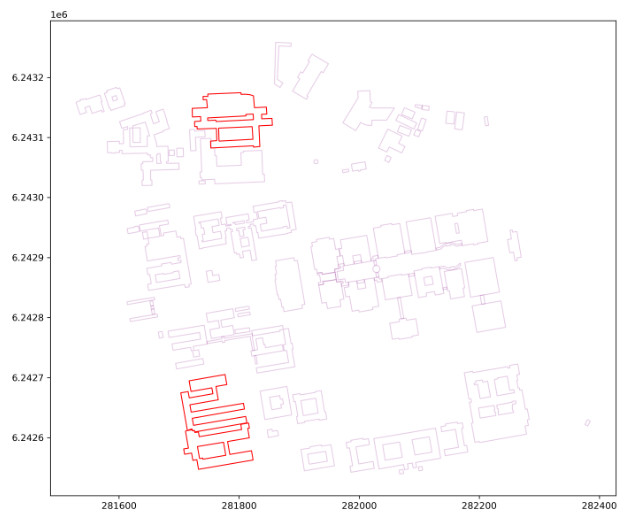 | **Challenges will be highlight in *Red*.**|
|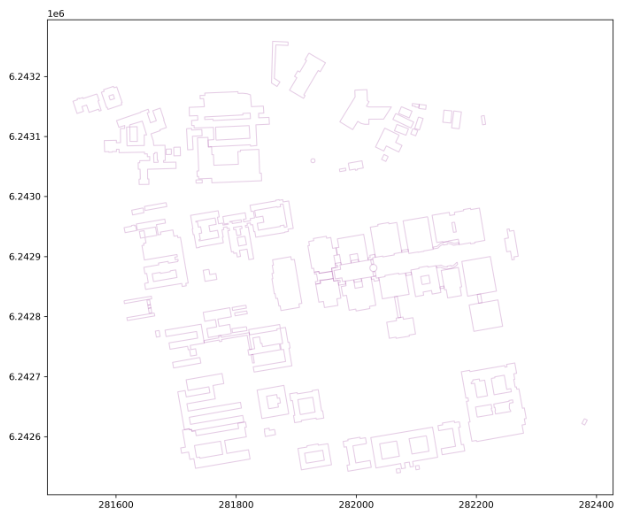 | **or none**|
|<br /> **If you continue without fixing the challenges, the LoD1 City Model *will not be error free*.** | <br /> **Our goal is a topologically correct surface.** |

<h2><center>Please ensure the quality of the value-added product and the source data.</center></h2>

**If necessary; edit [OpenStreetMap](https://www.openstreetmap.org/about) and fix the challenge please.**

<div class="alert alert-block alert-success"><b></b>
    
*And remember; give the OpenStreetMap server at **least a day** before attempting to work through this Notebook again.*  
*Alchemy is a process. **Please be patient**.*
</div>

In [23]:
#- get the mean height of the bld
ts['mean'] = ts.apply(lambda row: rasterQuery(row.geometry, gt_forward, rb), axis = 1)
ts.head(2)

,building,building:levels,addr:city,addr:postcode,addr:street,addr:suburb,amenity,denomination,heritage,name,...,street_vendor,brand,opening_date,self_service,capacity,type,osm_id,osm_type,geometry,mean
0,yes,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,328118446,way,POLYGON ((265041.6351569728 6289775.0592048075...,179.429993
1,church,2,Cape Town,7347,Kerk Street,Mamre,place_of_worship,moravian,building,Mamre Moravian Church,...,NaN,NaN,NaN,NaN,NaN,NaN,328118447,way,"POLYGON ((265070.9766813367 6289761.325392997,...",179.039993


In [24]:
#ts.geometry.unique()

<div class="alert alert-block alert-warning"><b>Calculate building height:</b> 

We assume a building level is 2.8 meters high and add another 1.3 meters (to account for the roof) and create a new attribute `height`.</div>

The Python code to execute the `.writejson` function is in the `city3D.py` script

In [25]:
# -- execute function. write geoJSON
dis = city3D.process_and_write_geojson(ts, jparams)

In [26]:
#- we only need structures that touch the ground

start = time.time()
        
dis.drop(dis.index[dis['building'] == 'bridge'], inplace = True)                           #- skywalk
dis.drop(dis.index[dis['building'] == 'roof'], inplace = True)

#- create a point representing the hole within each building  
#dis['x'] = dis.representative_point().x
#dis['y'] = dis.representative_point().y

dis["rep_point"] = dis["geometry"].apply(lambda g: g.representative_point())
dis["x"] = dis["rep_point"].apply(lambda p: p.x)
dis["y"] = dis["rep_point"].apply(lambda p: p.y)

hs = dis[['x', 'y', 'ground_height']].copy()

end = time.time()
print('runtime:', str(timedelta(seconds=(end - start))))

runtime: 0:00:00.017250


**prepare the elevation for the TIN**

In [27]:
#- 
dis_c = dis.copy()

In [28]:
#- prepare xyz (more buildings = more time)
start = time.time()

# Convert bytes to DataFrame
xyz_str = xyz_bytes.decode("utf-8")  # Decode to string

dtype_spec = {
    "x": np.float32,  # Reduce precision from float64 to float32 (saves memory)
    "y": np.float32,
    "z": np.float32
}

#df = pd.read_csv(jparams['xyz'], delimiter = ' ', header=None, names=["x", "y", "z"])                                                                                
df = pd.read_csv(pd.io.common.StringIO(xyz_str), delimiter=" ",  header=None, 
                 names=["x", "y", "z"], dtype=dtype_spec)                     # in memory fastest

#- create the shapely 'geometry' column directly (Vectorized) and 'plop' into home-baked gdf
df['geometry'] = df.apply(lambda row: Point(row['x'], row['y']), axis=1) 
gdf = city3D.GeoDataFrameLite(df) 
gdf.crs = epsg
#print(len(gdf))

# --- spatial Filtering with STRtree (Replacement for GeoPandas overlay) ---
aoi_geom = shapely.unary_union(aoibuffer['geometry'])
dis_geom = shapely.unary_union(dis_c['geometry'])

mask_geom = aoi_geom.symmetric_difference(dis_geom)
# Note: If mask_geom is a Multi-part geometry, we still need unary_union for STRtree query.
# Here we use the .unary_union property on the result to simplify:
#mask_geom = shapely.unary_union(mask_geom['geometry']) 

#- Create the Spatial Index
# This replaces: tree = STRtree(gdf.geometry)
tree = STRtree(gdf['geometry'].values) 

#- Query the Tree for Candidates
possible_matches_indices = tree.query(mask_geom, predicate='intersects')#[0]

#- Filter the DataFrame to candidate points
df_candidates = gdf.iloc[possible_matches_indices]

#- Apply the final, exact .within() filter
gdf = df_candidates[df_candidates['geometry'].apply(lambda geom: geom.within(mask_geom))]

# --- final cleanup ---
gdf = gdf[gdf['z'] != jparams['nodata']] 
gdf.reset_index(drop=True, inplace=True)
gdf = gdf.round(2)

end = time.time()
print('runtime:', str(timedelta(seconds=(end - start))))

runtime: 0:01:05.851989


<div class="alert alert-block alert-warning"><b>Prepare for Triangle:</b> </div>

The Python code to execute the `city3D.functions` are in the `city3D.py` script

In [29]:
#- harvest the building vertices. typically the corners. 
ac, c, min_zbld = city3D.getBldVertices(dis, gt_forward, rb)
idx = []
#- segments 
idx, idx01 = city3D.createSgmts(ac, c, gdf, idx)
#- populate the .df with coordinate values (the vertices)
df2 = city3D.concatCoords(gdf, ac)

#- do the same for the area of interest
acoi, ca = city3D.getAOIVertices(aoibuffer, gt_forward, rb)
idx, idx01 = city3D.createSgmts(acoi, ca, df2, idx)
df3 = city3D.concatCoords(df2, acoi)

**Triangle**

In [30]:
pv_pts = df3[['x', 'y', 'z']].values

In [31]:
holes01 = hs[['x', 'y']].round(3).values.tolist()
pts = df3[['x', 'y']].values #, 'z']].values

#the terrain without the blds
A = dict(vertices=pts, segments=idx, holes=holes01)

Tr = tr.triangulate(A, 'p')                  
terrTin = Tr.get('triangles').tolist()

**CityJSON**

In [32]:
#- 
minz = df3['z'].min()
maxz = df3['z'].max()

<div class="alert alert-block alert-warning"><b>create CityJSON</b> </div>

The Python code to execute the `.output_cityjson` function is in the `city3D.py` script

In [33]:
# -- execute function. create CityJSON
#crs = epsg[5:]

city3D.output_cityjson(extent, minz, maxz, terrTin, pv_pts, jparams, min_zbld, acoi, epsg) 

In [34]:
src_ds = None

<div class="alert alert-block alert-info"><b></b> 

**Go over to [Ninja the online CityJSON viewer](https://ninja.cityjson.org/#) and explore!**

</div>

**You are welcome to further investigate the quality of a 3D Model.**

**The [val3dity](http://geovalidation.bk.tudelft.nl/val3dity/) web app will test CityJSON geometric primitives.**

**If you parse the result of this notebook through [val3dity](http://geovalidation.bk.tudelft.nl/val3dity/) it will return a report with an invalid [TINRelief](https://www.cityjson.org/specs/1.1.1/#tinrelief) and error.**
<br>
<br>
<img src="./data/iso19107_error.jpg" width="450"/>
<br>
<br>
**This particular area contains Buildings with courtyards. The courtyards** (polygons) **are islands of terrain disconnected from the *larger* TINRelief** (shell); **thus the error<sup>*</sup>.**
<br>
<br>
<sup>* <sub>***Don't take my word for it. Test and see for yourself!*** `saao_param.json` (South African Royal Observatory, Cape Town) will produce a 100% topologically correct [Open Geospatial Consortium (OGC)](https://www.ogc.org/standard/citygml/) standard LoD1 3D model that conforms to the [ISO 19107 spatial schema for 3D primatives](https://www.iso.org/standard/66175.html) *[connecting and planar surfaces, correct orientation of the surfaces and watertight volumes]*</sub> 

<div class="alert alert-block alert-warning"><b>NOW</b><br><br>


***To understand the value and usefulness of a 3D City Model***; parse the result of this Notebook through [CityJSONspatialDataScience.ipynb](https://github.com/AdrianKriger/geo3D/blob/main/CityJSONspatialDataScience.ipynb) to workthrough an example of:  
- population estimation and
- a calculation of [Building Volume per Capita]((https://www.researchgate.net/publication/343185735_Building_Volume_Per_Capita_BVPC_A_Spatially_Explicit_Measure_of_Inequality_Relevant_to_the_SDGs)
</div>

***As always; you are welcome to raise an issue. I depend on you to help me improve.***

<a id='Section2'></a>

<div class="alert alert-block alert-success"><b>2. Possible Secondary and Tertiary level conversations starters:</b></div>

| **Topic**                                | **Secondary Level Questions**                                                                                                                                                                                   | **Tertiary Level Questions**                                                                                                                                                                                                                   |
|------------------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Geography** | - Talk about the main difference between a globe and a map, and why we use map projections to represent the Earth on a flat surface<br>- Explain why different map projections are used for different purposes. For example, why might a Mercator projection be useful for navigation, but not for comparing the sizes of countries? | - Discuss why it is necessary to convert geographic coordinates (latitude and longitude) to a projected coordinate system in the context of the geospatial sciences. What are some potential issues if this conversion is not done? <br>- How does geodesy contribute to the geospatial sciences?|

In [35]:
Tend = time.time()
print('runtime:', str(timedelta(seconds=(Tend - Tstart)))) #previous uEstate: 0:00:11.0471 | mamre: 0:03:46

runtime: 0:01:21.841580
